# Inaugural Project

In this project we investigate the time use of couples, working at home and in the labour market. We will be looking at the relative hourse of work spent at home. 

In question 1 we examin how the male relative to female working hours at home relative working hours at home $\frac{H_F}{H_M}$, from here on out: relative home hours. 

In question 2 we 

In [1]:
from types import SimpleNamespace

import numpy as np
from scipy import optimize

import pandas as pd 
import matplotlib.pyplot as plt
plt.style.use('ggplot')


from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm # for colormaps

# autoreload modules when code is run. Otherwise, python will not see recent changes. 
%load_ext autoreload
%autoreload 2

# Import your own code
#import inauguralproject
from inauguralproject import HouseholdSpecializationModelClass

# Question 1

In this question we solve for optimal hours spent for work,Illistration of $\frac{H_F}{H_M}$ for $\alpha \in \{ 0.25, 0.50, 0.75\}$ and $\sigma \in \{ 0.5, 1.0, 1.5\}$

**Calculating the optimal relative hours**

 Relativ hours worked given (alpha,sigma)
           0.5       1.0       1.5
0.25  0.545455  0.307692  0.214286
0.50  1.000000  1.000000  1.000000
0.75  1.833333  3.250000  4.666667
Plotting table


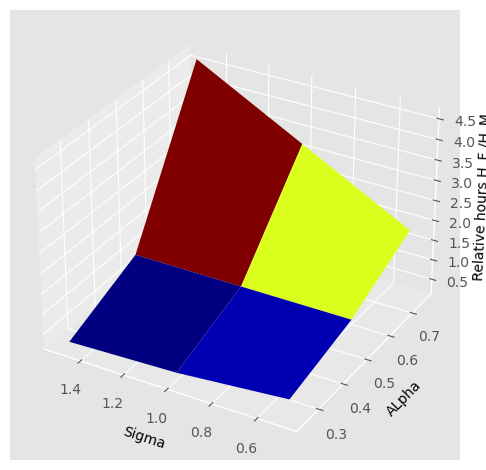

In [2]:
# 1. Create an instance of the model class
model_1 = HouseholdSpecializationModelClass()

# 2. Set parameter lists
list_alpha = [0.25, 0.5, 0.75]
list_sigma = [ 0.5, 1.0, 1.5]

# 3. Generate table
table = model_1.q1_gen_table(list_alpha,list_sigma)

# 4. Print table
print(f' Relativ hours worked given (alpha,sigma)')
print(table )

# 5.  3D plot of table 
print(f'Plotting table')
model_1.q1_plot_table(table)

**Ilistrations of the optimal relative hours** 

The effects of varrying $\alpha , \sigma$ can be seen in the folowing illistration. The illistration show that increase in $\alpha$ or $\sigma$ increase the hours worked at home by the female familiy member , relative to the male family member. 
This is in line with expectations from the model, as the parameters increase the productivity/importance of female hourse worked at home.

# Question 2

**Ploting relative wage discrete**

In this question we examin the relation between the relative hours worked at home, with the relative wage (log) for the discrete model.



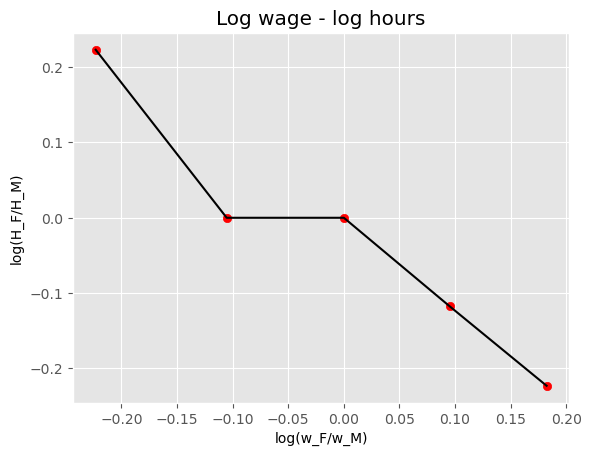

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Log wage - log hours'}, xlabel='log(w_F/w_M)', ylabel='log(H_F/H_M)'>)

In [3]:
# 1. Create an instance of the model class
model_2 = HouseholdSpecializationModelClass()

# 2. Set parameter lists
wF_vec = np.linspace(0.8,1.2,5)

# 3. solving for optimal hours worked given relative wages 
log_rel_wage, log_rel_hours = model_2.solve_wage_work(  discrete=True)

# 4. Plotting the results
model_2.q2_plot(log_rel_wage, log_rel_hours)


**Intuition**

The illistration shows that as the wage given to females rise, the optimal hours spent working at home fallse. The kink in the figure is due to the model being discrete. 

# Question 3

**Ploting relative wage continus**

In this question we examin the relation between the relative hours worked at home, with the relative wage (log) in a discrete model, where the choice of hours worked may be continus.



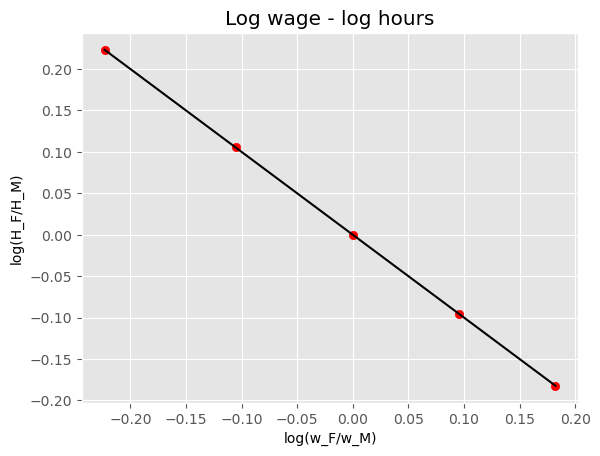

(<Figure size 640x480 with 1 Axes>,
 <Axes: title={'center': 'Log wage - log hours'}, xlabel='log(w_F/w_M)', ylabel='log(H_F/H_M)'>)

In [4]:
# 1. Create an instance of the model class
model_3 = HouseholdSpecializationModelClass()

# 2. Set parameter lists
wF_vec = np.linspace(0.8,1.2,5)

# 3. solving for optimal hours worked given relative wages
log_rel_wage, log_rel_hours = model_3.solve_wage_work( discrete=False)

# 4. Plotting the results
model_3.q2_plot(log_rel_wage, log_rel_hours)

**Intuition**

The figure follows the same intuition as in question 3. If females wage increase, they work more in teh work force, and therefore have less time to work at home. In this case there is no kink

# Question 4 #

For the model to fit the regression estimates, the parameters must be alpha = 0.98 and sigma = 0.10. That is, females are far more productive in working at home. This can be seen based on the following optimisation 

/Users/emmagundersen/Library/Mobile Documents/com~apple~CloudDocs/KU/sem_8/programing/projects-2023-mathias-emma-S-ren/inauguralproject/inauguralproject.py:73: RuntimeWarning: overflow encountered in double_scalars
  inside = ( (1-par.alpha)  * (HM) **(power) + par.alpha * (HF)**(power)  )


This gives the parameters: 
    alpha = 0.98 
    sigma = 0.10
 With the squared error 0.00


Text(0, 0.5, 'log(HF/HM)')

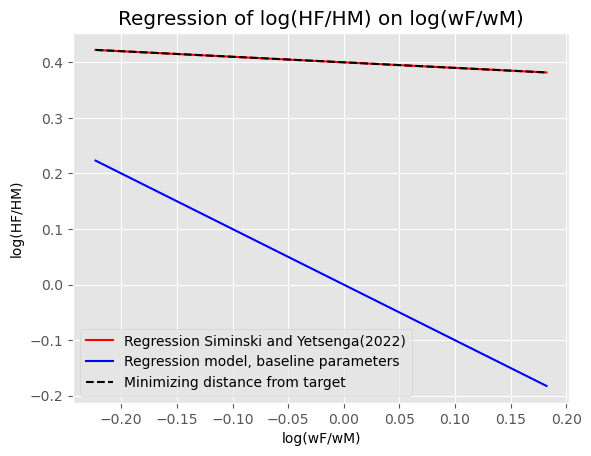

In [5]:
# 1. Create an instance of the model class
model_4 = HouseholdSpecializationModelClass()

# 1. Regressions parameters from paper
par = model_4.par
beta0_target = par.beta0_target
beta1_target = par.beta1_target


# 2:  Regression for origional parameters 

log_rel_wage, log_rel_hours = model_4.solve_wage_work( discrete=False)
# Regression coefisiten
beta0_base, beta1_base = model_4.run_regression(log_rel_wage, log_rel_hours) 

# 3:  Regression for minimizing the distance between the regression parameters and the target parameters
def obj(q):

    par.alpha, par.sigma = q

    log_rel_wage, log_rel_hours = model_4.solve_wage_work( discrete=False)

    # Regression coefisiten
    beta0, beta1 = model_4.run_regression(log_rel_wage, log_rel_hours) 

    error = (beta0 - beta0_target)**2 + (beta1 - beta1_target)**2

    return error

bounds = [(0, 0.999),(0.001, 2)]
initial_guess = (0.5, 1)
reg_opt = optimize.minimize(obj, initial_guess, method='Nelder-Mead', bounds=bounds, tol = 0.000000001) #Hvis tolerancen er høj, accepterer den løsninger som kun er tæt på at være rigtige

#Results from optimization
alpha_hat = reg_opt.x[0]
sigma_hat = reg_opt.x[1]
err = obj(reg_opt.x)

# Print results
print(f'This gives the parameters: \n    alpha = {alpha_hat:.2f} \n    sigma = {sigma_hat:.2f}')
print(f' With the squared error {err:.2f}')

# 4:  Regression for new parameters
par.alpha = alpha_hat
par.sigma = sigma_hat

log_rel_wage, log_rel_hours = model_4.solve_wage_work( discrete=False)
beta0_hat, beta1_hat = model_4.run_regression(log_rel_wage, log_rel_hours) 


fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.plot(log_rel_wage, beta0_target + beta1_target*log_rel_wage, label='Regression Siminski and Yetsenga(2022)', color='red')
ax.plot(log_rel_wage, beta0_base + beta1_base*log_rel_wage, label='Regression model, baseline parameters', color='blue')
ax.plot(log_rel_wage, beta0_hat + beta1_hat*log_rel_wage, label='Minimizing distance from target', color='black', linestyle='dashed')


#ax.plot(beta0_hat, log_rel_hours, label='Minimizing distance from target', color='black', linestyle='--')
ax.set_xlabel('log(wF/wM)')
ax.set_ylabel('log(HF/HM)')
ax.title.set_text('Regression of log(HF/HM) on log(wF/wM)')
ax.legend()
ax.set_xlabel('log(wF/wM)')
ax.set_ylabel('log(HF/HM)')

# Question 5 

This gives the parameters: 
    theta = 1.93 
    sigma = 0.01

 With the squared error 0.0093
 and the baseline error 0.9699


Text(0, 0.5, 'log(HF/HM)')

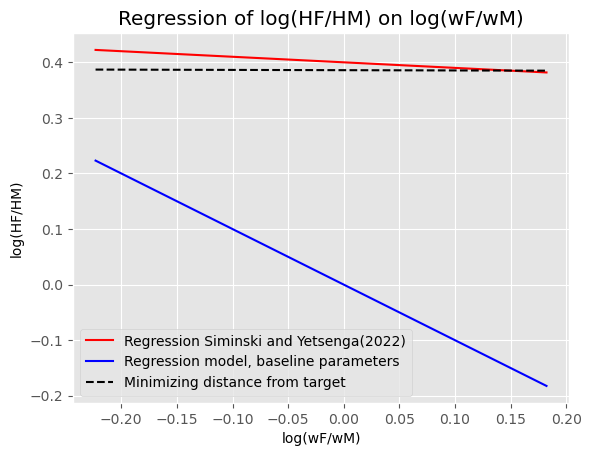

In [6]:
# 1. Create an instance of the model class
model_5 = HouseholdSpecializationModelClass()

# 1. Regressions parameters from paper
par = model_5.par
beta0_target = par.beta0_target
beta1_target = par.beta1_target


# 2:  Regression for origional parameters 
log_rel_wage, log_rel_hours = model_5.solve_wage_work( discrete=False)
# Regression coefisiten
beta0_base, beta1_base = model_5.run_regression(log_rel_wage, log_rel_hours) 
base_error = (beta0_base - beta0_target)**2 + (beta1_base - beta1_target)**2


# 3:  Regression for minimizing the distance between the regression parameters and the target parameters
def obj(q):

    par.theta, par.sigma = q

    log_rel_wage, log_rel_hours = model_5.solve_wage_work( discrete=False)

    # Regression coefisiten
    beta0, beta1 = model_5.run_regression(log_rel_wage, log_rel_hours) 

    error = (beta0 - beta0_target)**2 + (beta1 - beta1_target)**2

    return error

bounds = [(0, 10),(0.001, 1)]

initial_guess = (1, 0.5)
reg_opt = optimize.minimize(obj, initial_guess, method='Nelder-Mead', bounds=bounds, tol = 0.000001) 

#Results from optimization
theta_hat = reg_opt.x[0]
sigma_hat = reg_opt.x[1]


err = obj(reg_opt.x)

# Print results
print(f'This gives the parameters: \n    theta = {theta_hat:.2f} \n    sigma = {sigma_hat:.2f}\n')
print(f' With the squared error {err:.4f}\n and the baseline error {base_error:.4f}')

# 4:  Regression for new parameters
par.theta = theta_hat
par.sigma = sigma_hat


log_rel_wage, log_rel_hours = model_5.solve_wage_work( discrete=False)
beta0_hat, beta1_hat = model_5.run_regression(log_rel_wage, log_rel_hours) 


fig = plt.figure()
ax = fig.add_subplot(1,1,1)

ax.plot(log_rel_wage, beta0_target + beta1_target*log_rel_wage, label='Regression Siminski and Yetsenga(2022)', color='red')
ax.plot(log_rel_wage, beta0_base + beta1_base*log_rel_wage, label='Regression model, baseline parameters', color='blue')
ax.plot(log_rel_wage, beta0_hat + beta1_hat*log_rel_wage, label='Minimizing distance from target', color='black', linestyle='dashed')


#ax.plot(beta0_hat, log_rel_hours, label='Minimizing distance from target', color='black', linestyle='--')
ax.set_xlabel('log(wF/wM)')
ax.set_ylabel('log(HF/HM)')
ax.title.set_text('Regression of log(HF/HM) on log(wF/wM)')
ax.legend()
ax.set_xlabel('log(wF/wM)')
ax.set_ylabel('log(HF/HM)')
